In [33]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from joblib import Parallel, delayed
sys.path.append('../')

from packages import actv_analysis, svm, stats

## plot barplot (relu 2,3,4,5 vs shuffled counterparts)

In [ ]:
from itertools import product
import numpy as np
import pandas as pd

# Set up the ranges
nets = np.arange(1,3)
relus = np.arange(2,6)
epochs = np.arange(0,1,10)
num_units = 200
num_dist = np.arange(2,19,2)

# Create a DataFrame from the product of the ranges
df_svm_accuracy = pd.DataFrame(product(nets, relus, epochs), columns=['net', 'relu', 'epoch'])
df_svm_accuracy_shuffled = pd.DataFrame(product(nets, relus, epochs), columns=['net', 'relu', 'epoch'])
df_numdist_vs_accuracy = pd.DataFrame(product(nets, relus, epochs, num_dist), columns=['net', 'relu', 'epoch', 'num_dist'])

# Initialize the 'accuracy' column with NaNs or zeros (depending on your needs)
df_svm_accuracy['accuracy'] = np.nan
df_svm_accuracy_shuffled['accuracy'] = np.nan

for net in nets:
    for relu in relus:
        for epoch in epochs:
            for dist in num_dist:
                exp_results=[]
                exp_results_shuffled=[]
                exp_results_numdist=[]
                for exp in range(10):
                    # ...you should replace this with your actual csv file paths...
                    test_csv = f'csv/svm_test_set{exp}.csv'
                    pred_csv = f'csv/svm_results/SVM prediction of He untrained net{net} relu{relu} epoch{epoch} {num_units} nonzero activity units exp{exp} June2023.csv'
                    pred_csv_shuffled = f'csv/svm_results/SVM prediction of He untrained net{net} relu{relu} epoch{epoch} {num_units} nonzero activity units SHUFFLED exp{exp} June2023.csv'

                    test_exp = pd.read_csv(test_csv, index_col=0)
                    num_dists=np.abs(test_exp['num1']-test_exp['num2'])*2

                    # ...replace svm.get_y(test_exp) with your actual function to get y...
                    correct_answers = svm.get_y(test_exp).to_numpy()
                    svm_answers = pd.read_csv(pred_csv)['0'].to_numpy()
                    svm_answers_shuffled = pd.read_csv(pred_csv_shuffled)['0'].to_numpy()

                    is_equal = np.equal(correct_answers, svm_answers)
                    df_num_dist_correct = pd.DataFrame({'num_dists':num_dists, 'correct': is_equal}).groupby(['num_dists'])['correct'].mean().reset_index()

                    exp_results.append(np.sum(is_equal)/len(svm_answers)) 
                    exp_results_shuffled.append(np.sum(np.equal(correct_answers, svm_answers_shuffled))/len(svm_answers_shuffled)) 
                    exp_results_numdist.append(df_num_dist_correct)

                accuracy = np.mean(exp_results) 
                accuracy_shuffled = np.mean(exp_results_shuffled)
                exp_results_numdist_concat = pd.concat(exp_results_numdist).groupby(['num_dists'])['correct'].mean().reset_index()

                df_svm_accuracy.loc[(df_svm_accuracy['net'] == net) & 
                                    (df_svm_accuracy['relu'] == relu) & 
                                    (df_svm_accuracy['epoch'] == epoch), 
                                    'accuracy'] = accuracy

                df_svm_accuracy_shuffled.loc[(df_svm_accuracy_shuffled['net'] == net) & 
                                    (df_svm_accuracy_shuffled['relu'] == relu) & 
                                    (df_svm_accuracy_shuffled['epoch'] == epoch), 
                                    'accuracy'] = accuracy_shuffled

                df_numdist_vs_accuracy.loc[(df_numdist_vs_accuracy['net'] == net) & 
                                           (df_numdist_vs_accuracy['relu'] == relu) & 
                                           (df_numdist_vs_accuracy['epoch'] == epoch) &
                                           (df_numdist_vs_accuracy['num_dist'] == dist),
                                           'accuracy'] = exp_results_numdist_concat.loc[exp_results_numdist_concat['num_dists'] == dist, 'correct'].values[0] if not exp_results_numdist_concat.loc[exp_results_numdist_concat['num_dists'] == dist, 'correct'].empty else np.nan

            
# Add a 'source' column to each DataFrame to distinguish between them
df_svm_accuracy['source'] = 'Unshuffled'
df_svm_accuracy_shuffled['source'] = 'Shuffled'

# Concatenate the two DataFrames along the row axis
df_combined = pd.concat([df_svm_accuracy, df_svm_accuracy_shuffled], ignore_index=True)

# Use seaborn to create a bar plot with hue='source'
sns.barplot(data=df_combined, x='relu', y='accuracy', hue='source')


from scipy.stats import ttest_ind

# Get current axis
ax = plt.gca()

# Iterate over the unique "relu" values and their indices
for i, relu in enumerate(df_combined['relu'].unique()):

    # Filter dataframe by "relu"
    df_relu = df_combined[df_combined['relu'] == relu]

    # Calculate p-value
    t_stat, p_value = ttest_ind(df_relu[df_relu['source'] == "Unshuffled"]['accuracy'], df_relu[df_relu['source'] == "Shuffled"]['accuracy'])

    # Find position of bars
    x1 = i - 0.2  # Adjust these values as needed for your specific plot
    x2 = i + 0.2  # Adjust these values as needed for your specific plot
    y = df_relu['accuracy'].max() + 0.01

    # Draw the bracket
    ax.plot([x1, x1, x2, x2], [y, y+0.02, y+0.02, y], c='k')

    # Add p-value
    ax.text((x1+x2)*.5, y+0.02, f"p = {p_value:.3f}", ha='center', va='bottom', color='k')
    
plt.savefig('relu 2 3 4 5 svm results vs shuffled.pdf')    
plt.show()


## plot lineplot (relu 2,3,4,5 vs number distance)


In [ ]:
sns.set_palette('tab10')  # 'deep' is the default color palette
ax = sns.lineplot(data=df_numdist_vs_accuracy, x='num_dist', y='accuracy',hue='relu', palette='tab10')
ax.set_xlabel('numerical distance')

## barplot congruent vs incongruent in fully trained (epoch90) relu5 networks

In [2]:
nets = np.arange(1,11)
relus = np.arange(3,6)
epochs = np.arange(0,91,90)
num_units =200

exp_results = []
for net in nets:
    for relu in relus:
        for epoch in epochs:
            for exp in range(10):
                test_csv = f'csv/svm_test_set{exp}_4to20.csv'
                pred_csv = f'csv/svm_results/SVM prediction of He untrained net{net} relu{relu} epoch{epoch} {num_units} nonzero activity units exp{exp} July2023_4to20.csv'
                pred_csv_shuffled = f'csv/svm_results/SVM prediction of He untrained net{net} relu{relu} epoch{epoch} {num_units} nonzero activity units exp{exp} July2023_4to20_SHUFFLED.csv'
                test_exp = pd.read_csv(test_csv, index_col=0)

                correct_answers = svm.get_y(test_exp).to_numpy()
                svm_answers = pd.read_csv(pred_csv)['0'].to_numpy()
                svm_answers_shuffled = pd.read_csv(pred_csv_shuffled)['0'].to_numpy()
                is_equal = np.equal(correct_answers, svm_answers)
                is_equal_shuffled = np.equal(correct_answers, svm_answers_shuffled)

                cong = test_exp.index[((test_exp['num1']<test_exp['num2'])&(test_exp['sz1']<test_exp['sz2']))|((test_exp['num1']>test_exp['num2'])&(test_exp['sz1']>test_exp['sz2']))]
                incong = np.setdiff1d(range(len(test_exp)), cong)
                test_exp['net']=net
                test_exp['relu']=relu
                test_exp['epoch']=epoch
                test_exp['exp']=exp
                test_exp['number_ratio']=stats.number_ratio(np.arange(2,21,2), test_exp['num1'], test_exp['num2'])
                test_exp.loc[cong, 'congruence'] = 'C'
                test_exp.loc[incong, 'congruence'] = 'IC'
                test_exp['correct'] = is_equal
                test_exp['correct_shuffled'] = is_equal_shuffled  # add this line
                
                c_vs_ic = test_exp[['congruence', 'net', 'relu','epoch','exp','number_ratio','correct','correct_shuffled']].groupby(['congruence', 'net', 'relu','epoch','number_ratio','exp']).mean().reset_index()  # include 'correct_shuffled' here
                exp_results.append(c_vs_ic)

exp_results_concat = pd.concat(exp_results)[['congruence', 'net', 'relu','epoch','number_ratio','correct','correct_shuffled']].groupby(['congruence', 'net', 'relu','epoch']).mean().reset_index()  # include 'correct_shuffled' here too


FileNotFoundError: [Errno 2] No such file or directory: 'csv/svm_results/SVM prediction of He untrained net1 relu3 epoch0 200 nonzero activity units exp0 July2023_4to20.csv'

In [ ]:
exp_results_concat

### Plot

In [ ]:
from scipy.stats import ttest_ind


# Filter your dataframe based on 'relu' and 'epoch' conditions
exp_results_sub = exp_results_concat[(exp_results_concat['relu']==5)&(exp_results_concat['epoch']==90)]

# Reshape the dataframe to long format
exp_results_long = exp_results_sub.melt(id_vars=['congruence'], 
                                        value_vars=['correct', 'correct_shuffled'], 
                                        var_name='correct_type', 
                                        value_name='value')

# Sort correct_type in desired order
exp_results_long['correct_type'] = pd.Categorical(exp_results_long['correct_type'], 
                                                  categories=['correct', 'correct_shuffled'], 
                                                  ordered=True)

# Calculate the p-values for the difference between 'C' and 'IC' within each 'correct_type'
p_values = exp_results_long.groupby('correct_type').apply(lambda x: ttest_ind(
    x.loc[x['congruence'] == 'C', 'value'],
    x.loc[x['congruence'] == 'IC', 'value']
).pvalue)

# Now create a paired barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=exp_results_long, 
            x='correct_type', 
            y='value', 
            hue='congruence', 
            ci='sd')

plt.title('Comparison of Regular and Shuffled Data')
plt.xlabel('')
plt.ylabel('Average Value')
plt.ylim(0.4, None)

# Add horizontal red dotted line at y=0.5
plt.axhline(y=0.5, color='r', linestyle='--')

# Define positions for brackets and text
y_bracket = exp_results_long['value'].max() + 0.01  # adjust this value as needed
y_text = y_bracket + 0.01  # adjust this value as needed

# Add the p-values to the plot with brackets
for i, correct_type in enumerate(exp_results_long['correct_type'].cat.categories):
    plt.text(i, y_text, f'p = {p_values[correct_type]:.2e}', ha='center')
    plt.plot([i - 0.2, i - 0.2, i + 0.2, i + 0.2], [y_bracket, y_bracket + 0.01, y_bracket + 0.01, y_bracket], lw=1.5, color='black')

plt.savefig(f'barplot for SVM prediction of He untrained relu{relu} epoch{epoch} {num_units} nonzero activity units July2023_4to20.pdf')
plt.show()

### Plot lineplot

In [ ]:
df_num_ratio = pd.concat(exp_results)[['congruence', 'net', 'relu','epoch','number_ratio','correct']]
df_num_ratio['incorrect'] = 1-df_num_ratio['correct']
sns.lineplot(data=df_num_ratio, x='number_ratio',y='incorrect', hue='congruence')
plt.tight_layout()
plt.savefig(f'lineplot for numdist vs incorrect in SVM prediction of He untrained relu{relu} epoch{epoch} {num_units} nonzero activity units July2023_4to20.pdf')

## plot accuracy heatmap

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

net=1
num_units=200

for relu in range(5,6):
    epoch_results = []
    for epoch in np.arange(90,91,10):
        exp_results = []
        for exp in range(10):
            test_csv = f'csv/svm_test_set{exp}.csv'
            pred_csv = f'csv/svm_results/SVM prediction of He untrained net{net} relu{relu} epoch{epoch} {num_units} nonzero activity units exp{exp} June2023.csv'
            exp_results.append(svm.get_svm_matrix(test_csv, pred_csv))
        # Convert list of dataframes to 3D numpy array
        data_3d = np.array([df.to_numpy() for df in exp_results])

        # Compute mean along the first axis (the one representing different dataframes)
        with np.errstate(invalid='ignore'):
            avg_svm_matrix = np.nanmean(data_3d, axis=0)

        # Convert back to DataFrame (if desired)
        avg_svm_matrix_df = pd.DataFrame(avg_svm_matrix, index=exp_results[0].index, columns=exp_results[0].columns)
        epoch_results.append(avg_svm_matrix_df)

    # Create figure with 10 subplots arranged in a 5x2 grid
    fig, axes = plt.subplots(5, 2, figsize=(10,20))

    for i, ax in enumerate(axes.flat):
        df = epoch_results[i]
        sns.heatmap(df, cmap="rocket", ax=ax, annot=True, cbar_kws={'label': 'accuracy'})
        ax.set_xticklabels(np.arange(2, 21, 2))
        ax.set_yticklabels(np.arange(2, 21, 2))
        ax.set_title(f'Epoch {i*10}')
        ax.set_aspect('equal')

    plt.tight_layout()
    #plt.savefig(f'svm_heatmap_for_relu{relu}_all_epochs_top{num_units}_monotonic_response_units.pdf')
    plt.show()

## number of units used in SVM vs accuracy

In [ ]:
net=1
relu=2
epoch=90
num_units=2000

In [ ]:
accuracy_epochs = []
for epoch in range(0,91,10):
    accuracies = []
    for exp in range(10):
        test_csv = f'csv/svm_test_set{exp}.csv'
        pred_csv = f'csv/svm_results/SVM prediction of He untrained net{net} relu{relu} epoch{epoch} {num_units} nonzero activity units exp{exp} June2023.csv'

        test = pd.read_csv(test_csv).drop('Unnamed: 0', axis=1)
        pred = pd.read_csv(pred_csv)['0'].to_numpy()
        ans = svm.get_y(pd.read_csv(test_csv).drop('Unnamed: 0', axis=1))  # Assumes that get_y is defined elsewhere
        # Check for equality element-wise:
        equal_elements = np.equal(pred, ans)
        accuracies.append(np.sum(equal_elements)/len(test))
    accuracy = np.mean(accuracies)
    accuracy_epochs.append(accuracy)

In [ ]:
from itertools import product
# define the range for each variable
nets = np.arange(1,3)
relus = np.arange(5, 6, 1).astype(int)
epochs = np.arange(0, 91, 10).astype(int)
num_units = np.arange(200, 2001, 400).astype(int)

# Create a cartesian product of all three lists
all_combinations = list(product(nets, relus, epochs, num_units))

# Convert the combinations into a dataframe
df = pd.DataFrame(all_combinations, columns=['net', 'relu', 'epoch', 'num_units'])

# Initially set accuracy to NaN (or some other default value)
df['accuracy'] = np.nan

In [ ]:
for idx, row in df.iterrows():
    net = int(row['net'])
    relu = int(row['relu'])
    epoch = int(row['epoch'])
    num_units = int(row['num_units'])

    accuracies = []
    for exp in range(10):
        test_csv = f'csv/svm_test_set{exp}.csv'
        pred_csv = f'csv/svm_results/SVM prediction of He untrained net{net} relu{relu} epoch{epoch} {num_units} nonzero activity units exp{exp} June2023.csv'

        test = pd.read_csv(test_csv).drop('Unnamed: 0', axis=1)
        pred = pd.read_csv(pred_csv)['0'].to_numpy()
        ans = svm.get_y(pd.read_csv(test_csv).drop('Unnamed: 0', axis=1))  # Assumes that get_y is defined elsewhere

        # Check for equality element-wise:
        equal_elements = np.equal(pred, ans)
        accuracies.append(np.sum(equal_elements)/len(test))

    df.at[idx, 'accuracy'] = np.mean(accuracies)


In [ ]:
# Convert 'num_units' to a categorical type
df['num_units'] = df['num_units'].astype('category')

# Create a cubehelix color palette
palette = sns.color_palette("cubehelix", len(df['num_units'].unique()))

sns.lineplot(data=df, x='epoch', y='accuracy', hue='num_units', palette=palette)
plt.yticks = np.arange(0,91,10)
plt.title(f'Relu{relu} epoch vs accuracy per number of units used in svm')
plt.tight_layout()
plt.savefig(f'Relu{relu} epoch vs accuracy per number of units used in svm.pdf')
plt.show()

## Epoch vs accuracy in Relu5

In [34]:
nets = np.arange(1,11)
relus = np.arange(4,5)
epochs = np.arange(0,91,10)
num_units =np.arange(2000,2001,200)

exp_results = []
for num_unit in num_units:
    for net in nets:
        for relu in relus:
            for epoch in epochs:
                for exp in range(10):
                    test_csv = f'csv/svm_test_set{exp}_4to20.csv'
                    pred_csv = f'csv/svm_results/4to20/SVM prediction of He untrained net{net} relu{relu} epoch{epoch} {num_unit} nonzero activity units exp{exp} July2023_4to20.csv'
                    #pred_csv_shuffled = f'csv/svm_results/SVM prediction of He untrained net{net} relu{relu} epoch{epoch} {num_units} nonzero activity units exp{exp} July2023_4to20_SHUFFLED.csv'
                    test_exp = pd.read_csv(test_csv, index_col=0)

                    correct_answers = svm.get_y(test_exp).to_numpy()
                    svm_answers = pd.read_csv(pred_csv)['0'].to_numpy()
                    #svm_answers_shuffled = pd.read_csv(pred_csv_shuffled)['0'].to_numpy()
                    is_equal = np.equal(correct_answers, svm_answers)
                    #is_equal_shuffled = np.equal(correct_answers, svm_answers_shuffled)

                    cong = test_exp.index[((test_exp['num1']<test_exp['num2'])&(test_exp['sz1']<test_exp['sz2']))|((test_exp['num1']>test_exp['num2'])&(test_exp['sz1']>test_exp['sz2']))]
                    incong = np.setdiff1d(range(len(test_exp)), cong)
                    test_exp['num_unit']=num_unit
                    test_exp['net']=net
                    test_exp['relu']=relu
                    test_exp['epoch']=epoch
                    test_exp['exp']=exp
                    test_exp['number_ratio']=stats.number_ratio(np.arange(2,21,2), test_exp['num1'], test_exp['num2'])
                    test_exp['number_dist']=np.abs(test_exp['num1']-test_exp['num2'])*2
                    test_exp.loc[cong, 'congruence'] = 'C'
                    test_exp.loc[incong, 'congruence'] = 'IC'
                    test_exp['correct'] = is_equal
                    #test_exp['correct_shuffled'] = is_equal_shuffled  # add this line

                    c_vs_ic = test_exp[['congruence', 'net', 'relu','epoch','exp','number_ratio','number_dist','correct', 'num_unit']].groupby(['congruence', 'net', 'relu','epoch','number_ratio','number_dist','exp','num_unit']).mean('accuracy').reset_index()  # include 'correct_shuffled' here
                    exp_results.append(c_vs_ic)

exp_results_concat = pd.concat(exp_results)

In [35]:
exp_results_concat

,congruence,net,relu,epoch,number_ratio,number_dist,exp,num_unit,correct
0,C,1,4,0,0.200000,16,0,2000,1.000000
1,C,1,4,0,0.222222,14,0,2000,1.000000
2,C,1,4,0,0.250000,12,0,2000,1.000000
3,C,1,4,0,0.285714,10,0,2000,1.000000
4,C,1,4,0,0.300000,14,0,2000,1.000000
...,...,...,...,...,...,...,...,...,...
67,IC,10,4,90,0.833333,2,9,2000,0.995536
68,IC,10,4,90,0.857143,2,9,2000,0.982143
69,IC,10,4,90,0.875000,2,9,2000,0.959821
70,IC,10,4,90,0.888889,2,9,2000,0.977679


In [37]:
ff = exp_results_concat[['congruence','net','relu','epoch','number_ratio','number_dist','num_unit','correct']].groupby(['congruence','net','relu','number_ratio','number_dist','epoch','num_unit']).mean('correct').reset_index()

# Pivot the dataframe to have 'congruence' as columns
pivot_df = ff.pivot_table(index=['net', 'relu', 'epoch', 'number_ratio','number_dist','num_unit'], columns='congruence', values='correct').reset_index()

# Compute the difference between 'C' and 'IC'
pivot_df['cong_diff'] = pivot_df['C'] - pivot_df['IC']

## Heatmap: epoch vs relu for congruence effect

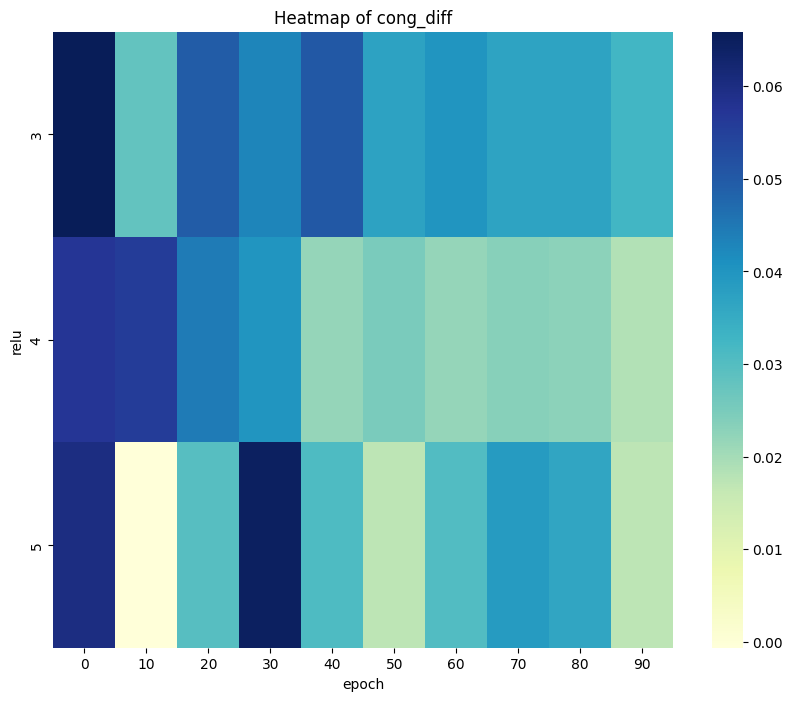

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Reshape the dataframe using pivot_table function
heatmap_data = pivot_df.pivot_table(index='relu', columns='epoch', values='cong_diff', aggfunc='mean')

plt.figure(figsize=(10,8))
# Create the heatmap
sns.heatmap(heatmap_data, cmap="YlGnBu")

plt.title('Heatmap of cong_diff')
plt.show()

## Lineplot: epoch vs relu for congruence effect

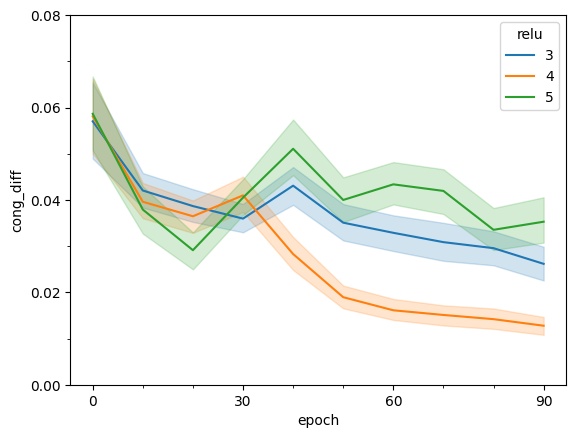

In [21]:
from matplotlib.ticker import MultipleLocator

sns.lineplot(data=pivot_df, x='epoch', y='cong_diff', hue='relu', palette='tab10')
# Set major ticks
plt.xticks([0,30,60,90])
plt.yticks([0,0.02,0.04,0.06,0.08])

# Set minor ticks
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_minor_locator(MultipleLocator(10))  # Set minor ticks for x-axis every 10 units
ax.yaxis.set_minor_locator(MultipleLocator(0.01))  # Set minor ticks for y-axis every 0.01 units
plt.savefig('Lineplot for Epoch vs congruency effect.pdf')
plt.show()

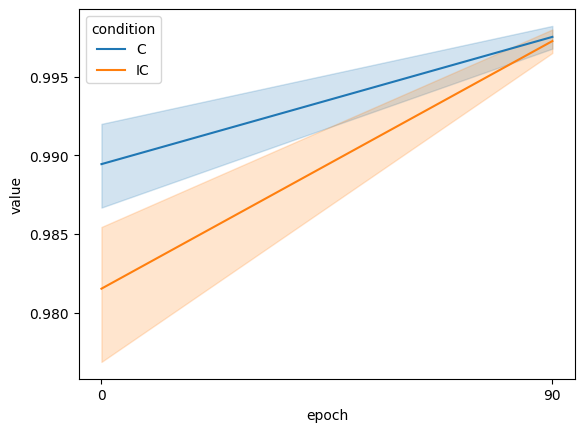

Paired t-test for 'C': t = -7.867172049891708, p = 4.309062045355783e-14
Wilcoxon signed-rank test for 'C': W = 15.5, p = 1.3326400775369559e-21


In [38]:
# Filter pivot_df to include only relu 4 and epoch 0 and 90
df_sub = pivot_df[(pivot_df['epoch'].isin([0, 90])) & (pivot_df['relu'] == 4)]

# "Melt" the 'C' and 'IC' columns into rows
df_melted = pd.melt(df_sub, id_vars=['net', 'relu', 'epoch'], value_vars=['C', 'IC'], var_name='condition', value_name='value')

# Create lineplot
sns.lineplot(data=df_melted, x='epoch', y='value', hue='condition')

# Set xticks
plt.xticks([0, 90])

# Show plot
plt.show()

from scipy import stats

# For paired t-test
t_stat, p_val = stats.ttest_rel(df_sub[df_sub['epoch'] == 0]['C'], df_sub[df_sub['epoch'] == 90]['C'])
print(f"Paired t-test for 'C': t = {t_stat}, p = {p_val}")

# For Wilcoxon signed-rank test
w_stat, p_val = stats.wilcoxon(df_sub[df_sub['epoch'] == 0]['C'], df_sub[df_sub['epoch'] == 90]['C'])
print(f"Wilcoxon signed-rank test for 'C': W = {w_stat}, p = {p_val}")

In [ ]:
import matplotlib.ticker as mtick

ff = exp_results_concat[['congruence','net','relu','epoch','number_ratio','num_unit','correct']].groupby(['congruence','net','relu','number_ratio','epoch','num_unit']).mean('correct').reset_index()

# Pivot the dataframe to have 'congruence' as columns
pivot_df = ff[ff['number_ratio']>=0.2].pivot_table(index=['net', 'relu', 'epoch', 'number_ratio','num_unit'], columns='congruence', values='correct')

# Compute the difference between 'C' and 'IC'
pivot_df['cong_diff'] = pivot_df['C'] - pivot_df['IC']

# Reset the index
pivot_df = pivot_df.reset_index()

# Reshape the dataframe
reshaped_df = pivot_df.pivot_table(index=['net','num_unit'], columns='epoch', values='cong_diff').reset_index()

# Get the unique num_units
num_units = reshaped_df['num_unit'].unique()

# Create a dictionary to store the p-values for each num_unit
p_values = {}

# For each num_unit, perform a t-test comparing 'cong_effect' at epoch0 and epoch90
for unit in num_units:
    unit_data = reshaped_df[reshaped_df['num_unit'] == unit]
    t_stat, p_value = stats.ttest_rel(unit_data[0], unit_data[90])
    p_values[unit] = p_value

# Create a DataFrame from the p_values dictionary
p_values_df = pd.DataFrame(list(p_values.items()), columns=['num_unit', 'p_value'])

# Annotate significance
p_values_df['significant'] = p_values_df['p_value'] < 0.01

# Merge p_values_df back with pivot_df
pivot_df = pd.merge(pivot_df, p_values_df, how='left', on='num_unit')

# Plotting
color_dict = dict(zip(pivot_df['epoch'].unique(), ['blue', 'red']))
sns.lineplot(data=pivot_df, x='num_unit', y='cong_diff', hue='epoch', palette=color_dict)

plt.ylim(0,)  # Set y-axis to start from 0
plt.xticks(np.arange(200, 2001, 200))  # Set x-ticks from 200 to 2000 with step size of 200
plt.xlabel('number of units used for SVM')
plt.ylabel('congruency effect')

# Convert y-axis values to percentages
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.savefig('congruency_effect_epoch0_vs_epoch90.pdf')
plt.show()

# Print p-values
print(p_values_df)

In [ ]:
sns.lineplot(data= exp_results_concat, x='epoch', y='correct', hue='congruence')

In [ ]:
exp_results_concat

## epoch & number distance vs congruency effect (accuracy of congruent - incongruent)

In [ ]:
def get_num_sz_dist(test):
    df_num_sz_dist = pd.DataFrame(index=range(len(test)), columns=['num_dist', 'sz_dist', 'congruency']) 
    df_num_sz_dist['num_dist'] = (test['num1'] - test['num2']) * 2
    df_num_sz_dist['sz_dist'] = test['sz1'] - test['sz2']
    df_num_sz_dist['congruency'] = np.sign(df_num_sz_dist['num_dist']) == np.sign(df_num_sz_dist['sz_dist']) 
    return df_num_sz_dist

In [ ]:
from itertools import product
# define the range for each variable
nets = np.arange(1,3)
relus = np.arange(5, 6, 1).astype(int)
epochs = np.arange(0, 91, 10).astype(int)
num_units = np.arange(200, 2001, 400).astype(int)

# Create a cartesian product of all three lists
all_combinations = list(product(nets, relus, epochs, num_units))

# Convert the combinations into a dataframe
df = pd.DataFrame(all_combinations, columns=['net', 'relu', 'epoch', 'num_units'])

# Initially set accuracy to NaN (or some other default value)
df['accuracy'] = np.nan


for idx, row in df.iterrows():
    net = int(row['net'])
    relu = int(row['relu'])
    epoch = int(row['epoch'])
    num_units = int(row['num_units'])

    accuracies = []
    for exp in range(10):
        test_csv = f'csv/svm_test_set{exp}.csv'
        pred_csv = f'csv/svm_results/SVM prediction of He untrained net{net} relu{relu} epoch{epoch} {num_units} nonzero activity units exp{exp} June2023.csv'

        test = pd.read_csv(test_csv).drop('Unnamed: 0', axis=1)
        df_num_sz_dist = get_num_sz_dist(test)
        pred = pd.read_csv(pred_csv)['0'].to_numpy()
        ans = svm.get_y(pd.read_csv(test_csv).drop('Unnamed: 0', axis=1))  # Assumes that get_y is defined elsewhere

        # Check for equality element-wise:
        equal_elements = np.equal(pred, ans)
        df_num_sz_dist['correctly_predicted'] = equal_elements

In [ ]:
from itertools import product

# Define the ranges
nets = range(1, 2)
relus = range(5, 6)
num_units_values = range(2000, 2001, 200)
epochs = range(0, 91, 10)

# Generate all combinations
combinations = product(nets, relus, num_units_values, epochs)

# Convert to a DataFrame
df = pd.DataFrame(combinations, columns=['net', 'relu', 'num_units', 'epoch'])

# Add the 'cong_effect' column
df['cong_effect'] = np.nan

for net in range(1,2):
    for relu in range(5,6):
        for num_units in range(2000,2001,200):
            for epoch in range(0,91,10):
                test_csv = f'csv/svm_test_set{exp}.csv'
                pred_csv = f'csv/svm_results/SVM prediction of He untrained net{net} relu{relu} epoch{epoch} {num_units} nonzero activity units exp{exp} June2023.csv'

                test = pd.read_csv(test_csv).drop('Unnamed: 0', axis=1)
                df_num_sz_dist = get_num_sz_dist(test)
                pred = pd.read_csv(pred_csv)['0'].to_numpy()
                ans = svm.get_y(pd.read_csv(test_csv).drop('Unnamed: 0', axis=1))  # Assumes that get_y is defined elsewhere

                # Check for equality element-wise:
                equal_elements = np.equal(pred, ans)
                df_num_sz_dist['correctly_predicted'] = equal_elements

                #accs  = []
                for nd in range(2,19,2):
                    df_numdist = df_num_sz_dist[np.abs(df_num_sz_dist['num_dist']) == nd]
                    df_numdist_cong = df_numdist[df_numdist['congruency']==True]
                    accuracy_cong = np.sum(df_numdist_cong['correctly_predicted'])/len(df_numdist_cong)
                    df_numdist_incong = df_numdist[df_numdist['congruency']==False]
                    accuracy_incong = np.sum(df_numdist_incong['correctly_predicted'])/len(df_numdist_incong)
                    cong_effect = accuracy_cong - accuracy_incong
                    #accs.append(cong_effect)
                    # Fill df at the appropriate location            

In [ ]:
# Define the ranges
nets = range(1, 3)
relus = range(2, 6)
num_units_values = range(200, 2001, 200)
epochs = range(0, 91, 10)
num_dists = range(2, 19, 2)

# Generate all combinations
combinations = product(nets, relus, num_units_values, epochs, num_dists)

# Convert to a DataFrame
df = pd.DataFrame(combinations, columns=['net', 'relu', 'num_units', 'epoch', 'num_dist'])

# Add the 'cong_effect' column
df['cong_effect'] = np.nan

for index, row in df.iterrows():
    net = int(row['net'])
    relu = int(row['relu'])
    num_units = int(row['num_units'])
    epoch = int(row['epoch'])
    num_dist = int(row['num_dist'])
    
    test_csv = f'csv/svm_test_set{exp}.csv'
    pred_csv = f'csv/svm_results/SVM prediction of He untrained net{net} relu{relu} epoch{epoch} {num_units} nonzero activity units exp{exp} June2023.csv'

    test = pd.read_csv(test_csv).drop('Unnamed: 0', axis=1)
    df_num_sz_dist = get_num_sz_dist(test)
    pred = pd.read_csv(pred_csv)['0'].to_numpy()
    ans = svm.get_y(pd.read_csv(test_csv).drop('Unnamed: 0', axis=1))  # Assumes that get_y is defined elsewhere

    # Check for equality element-wise:
    equal_elements = np.equal(pred, ans)
    df_num_sz_dist['correctly_predicted'] = equal_elements

    df_numdist = df_num_sz_dist[np.abs(df_num_sz_dist['num_dist']) == num_dist]
    df_numdist_cong = df_numdist[df_numdist['congruency']==True]
    accuracy_cong = np.sum(df_numdist_cong['correctly_predicted'])/len(df_numdist_cong)
    df_numdist_incong = df_numdist[df_numdist['congruency']==False]
    accuracy_incong = np.sum(df_numdist_incong['correctly_predicted'])/len(df_numdist_incong)
    cong_effect = accuracy_cong - accuracy_incong

    # Fill df at the appropriate location
    df.at[index, 'cong_effect'] = cong_effect

### Generate congruency effect heatmap per network and relu

In [ ]:
min_val = df['cong_effect'].min()
max_val = df['cong_effect'].max()

for net in nets:
    for relu in relus:
        for num_unit in num_units_values:
            df_sub = df[(df['net']==net) & (df['relu']==relu) & (df['num_units']==num_unit)]
            
            # Reshape the dataframe
            pivot_df = df_sub.pivot(index='num_dist', columns='epoch', values='cong_effect')

            # Create the heatmap
            plt.figure(figsize=(10, 8))
            sns.heatmap(pivot_df, annot=True, cmap='rocket', vmin=min_val, vmax=max_val)
            plt.title(f'Congruency effect net{net} relu {relu} {num_unit} units')
            plt.savefig(f'heatmap for congruency effect of net{net} relu{relu} epoch{epoch} {num_unit} nonzero activity units July2023.pdf')
            #plt.show()

### Generate congruency effect heatmap per relu (averaged across networks)

In [ ]:
# Calculate average 'cong_effect' across all nets
df_avg = df.groupby(['num_dist', 'epoch', 'relu', 'num_units']).mean().reset_index()

# Find global min and max of 'cong_effect'
min_val = df_avg['cong_effect'].min()
max_val = df_avg['cong_effect'].max()

for relu in range(3,6):
    for num_unit in num_units_values:
        df_sub = df_avg[(df_avg['relu']==relu) & (df_avg['num_units']==num_unit)]

        # Reshape the dataframe
        pivot_df = df_sub.pivot(index='num_dist', columns='epoch', values='cong_effect')

        # Create the heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(pivot_df, annot=True, cmap='rocket', vmin=min_val, vmax=max_val)
        plt.title(f'Average congruency effect for relu {relu} with {num_unit} units')
        plt.savefig(f'heatmap for average congruency effect of relu{relu} with {num_unit} units July2023.pdf')
        #plt.show()

In [ ]:
import math

# Calculate average 'cong_effect' across all nets
df_avg = df.groupby(['num_dist', 'epoch', 'relu', 'num_units']).mean().reset_index()

# Find global min and max of 'cong_effect'
min_val = df_avg['cong_effect'].min()
max_val = df_avg['cong_effect'].max()

for relu in range(2, 6):
    # Define number of rows and columns for subplot
    num_unit_len = len(num_units_values)
    num_cols = 2
    num_rows = math.ceil(num_unit_len / num_cols)

    # Create figure and axes for each relu
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(10 * num_cols, 8 * num_rows))  # Adjust the figure size

    # To handle cases when the number of subplots is not exactly filling the grid
    axs = axs.ravel()

    for i, num_unit in enumerate(num_units_values):
        df_sub = df_avg[(df_avg['relu'] == relu) & (df_avg['num_units'] == num_unit)]

        # Reshape the dataframe
        pivot_df = df_sub.pivot(index='num_dist', columns='epoch', values='cong_effect')

        # Create the heatmap on specific subplot
        sns.heatmap(pivot_df, annot=True, cmap='rocket', vmin=min_val, vmax=max_val, ax=axs[i])
        axs[i].set_title(f'Average congruency effect for relu {relu} with {num_unit} units')

    # Remove unused subplots
    for j in range(i+1, num_rows * num_cols):
        fig.delaxes(axs[j])

    # Save the full figure for each relu
    plt.tight_layout()
    plt.savefig(f'heatmaps for average congruency effect of relu {relu} July2023.pdf')
    plt.show()

### Lineplot for epoch vs congruency effect (for num units used 200)

In [ ]:
# Get unique num_dist values
num_dist_values = df['num_dist'].unique()

# Define number of rows and columns for subplot
num_dist_len = len(num_dist_values)
num_cols = 3  # Number of columns in the subplot grid
num_rows = int(np.ceil(num_dist_len / num_cols))  # Calculate number of rows needed

# Create figure and axes for each num_dist
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10*num_cols, 8*num_rows))  # Adjust the figure size

# Flatten axs for easy iteration
axs = axs.flatten()

# Determine the global y-axis limits
global_y_min = df['cong_effect'].min()
global_y_max = df['cong_effect'].max()

# Get the unique 'relu' values and create a color map for them
relu_values = df['relu'].unique()

# Make sure the length of relu_values does not exceed the number of specified colors
assert len(relu_values) <= 4, "There are more 'relu' values than colors specified"

colors = ['red', 'orange', 'green', 'blue']
color_dict = dict(zip(relu_values, colors))

for i, num_dist in enumerate(num_dist_values):
    df_sub = df[(df['num_dist']==num_dist)&(df['num_units']==200)]

    # Create the line plot on specific subplot
    sns.lineplot(data=df_sub, x='epoch', y='cong_effect', hue='relu', palette=color_dict, ax=axs[i])
    axs[i].set_title(f'Congruency effect for num_dist {num_dist}', fontsize=20)

    # Set the same y-axis limit for all subplots
    axs[i].set_ylim(global_y_min, global_y_max)

    # Set the x-ticks
    axs[i].set_xticks(range(0, 91, 10))
    
    # Set x-axis and y-axis label size
    axs[i].tick_params(axis='x', labelsize=16)
    axs[i].tick_params(axis='y', labelsize=16)

    # Increase legend size
    leg = axs[i].legend()
    for t in leg.texts:
        t.set_fontsize(16)
        
    # Increase axes label size
    axs[i].xaxis.label.set_size(16)
    axs[i].yaxis.label.set_size(16)
    
    axs[i].set_ylabel("congruency effect", fontsize=16)

# Remove empty subplots
if num_dist_len % num_cols != 0:
    for ax in axs[num_dist_len:]:
        fig.delaxes(ax)

# Set the layout to tight to avoid overlapping
plt.tight_layout()
plt.show()

### Lineplot for Relu vs Congruency effect per epoch number distance (a figure per number distance)

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt

for nd in np.arange(2,19,2):

    # Generate line plot
    df_sub = df[(df['num_units']==200) & (df['num_dist']==nd)]
    ax = sns.lineplot(data=df_sub, x='relu',y='cong_effect',hue='epoch',err_style='bars', palette='viridis')

    # Set x-ticks
    ax.set_xticks(range(3,6))

    # Draw a red dotted horizontal line at y=0
    ax.axhline(0, color='red', linestyle='--')

    # Set y-label
    ax.set_ylabel('Congruency Effect')

    # Move legend outside the figure
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # shrink figure by 15%
    legend = ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1) 

    # Set the legend title
    legend.set_title('epoch')
    ax.set_title(f'number distance:{nd}')
    plt.tight_layout()
    plt.savefig(f'Lineplot for Relu vs Congruency effect per epoch number distance {num_dist}.pdf')
    plt.show()

### Lineplot for Relu vs Congruency effect per epoch number distance (a subplots)

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Define the size and layout of the subplots
num_dist_values = np.arange(2,7,2)
num_dist_len = len(num_dist_values)
num_cols = 3
num_rows = int(np.ceil(num_dist_len / num_cols))

# Create the figure and axes for the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5))

# Flatten the axes for easy iteration
axs = axs.flatten()

# Get global y-axis limits
global_y_min = df['cong_effect'].min()
global_y_max = df['cong_effect'].max()

lines_labels = []

for i, nd in enumerate(num_dist_values):
    # Generate line plot
    df_sub = df[(df['num_units']==200) & (df['num_dist']==nd)]
    ax = sns.lineplot(data=df_sub, x='relu', y='cong_effect', hue='epoch', err_style='bars', palette='viridis', ax=axs[i])

    # Set y-axis limits
    axs[i].set_ylim(global_y_min, global_y_max)

    # Set x-ticks
    axs[i].set_xticks(range(2,6))

    # Draw a red dotted horizontal line at y=0
    axs[i].axhline(0, color='red', linestyle='--')

    # Set y-label
    axs[i].set_xlabel('ReLu')
    axs[i].set_ylabel('Congruency Effect')

    # Set subplot title
    axs[i].set_title(f'number distance: {nd}')

    # Get the Line2D objects from the Axes object
    lines, labels = ax.get_legend_handles_labels()
    lines_labels.append((lines, labels))

    # Remove the legend of each subplot
    ax.get_legend().remove()

# Remove extra subplots
if num_dist_len % num_cols != 0:
    for ax in axs[num_dist_len:]:
        fig.delaxes(ax)

# Adjust layout to avoid overlapping
plt.tight_layout()

# Create a new legend for the figure using the handles and labels we collected
lines, labels = lines_labels[0]  # All subplots have the same legend, so use the first one
fig.legend(lines, labels, title='epoch', loc='lower center', ncol=len(lines), bbox_to_anchor=(0.5, -0.1))
plt.tight_layout()
# Save the figure
plt.savefig('Lineplot for Relu vs Congruency effect per epoch for different number distances.pdf',bbox_inches='tight')

# Show the figure
plt.show()

## Analysis of how different types of monotonic units (LNLS and LNSS) affect learning

In [ ]:
# Define the ranges
nets = range(1, 3)
relus = range(4, 5)
num_units_values = range(200, 201, 200)
epochs = range(90, 91, 10)
num_dists = range(2, 19, 2)
LNSS_prop = np.arange(0,1.1,0.1)


# Generate all combinations
combinations = product(nets, relus, num_units_values, epochs, LNSS_prop, num_dists)

# Convert to a DataFrame
df = pd.DataFrame(combinations, columns=['net', 'relu', 'num_units', 'epoch', 'LNSS_prop', 'num_dist'])

# Add the 'cong_effect' column
df['cong_effect'] = np.nan

for index, row in df.iterrows():
    net = int(row['net'])
    relu = int(row['relu'])
    num_units = int(row['num_units'])
    epoch = int(row['epoch'])
    num_dist = int(row['num_dist'])
    LNSS_prop = round(row['LNSS_prop'], 1)
    LNLS_prop = round(1-LNSS_prop, 1)
    pred_csv = f'csv/svm_results/SVM_prediction_of_He_untrained_net{net}_relu{relu}_epoch{epoch}_{int(100*LNSS_prop)}_percent_LNSS_and_{int(100*LNLS_prop)}_percent_LNLS_units_exp{exp}_July2023.csv'
    
    test_csv = f'csv/svm_test_set{exp}.csv'
    pred_csv = f'csv/svm_results/SVM_prediction_of_He_untrained_net{net}_relu{relu}_epoch{epoch}_{int(100*LNSS_prop)}_percent_LNSS_and_{int(100*LNLS_prop)}_percent_LNLS_units_exp{exp}_July2023.csv'

    test = pd.read_csv(test_csv).drop('Unnamed: 0', axis=1)
    df_num_sz_dist = get_num_sz_dist(test)
    pred = pd.read_csv(pred_csv)['y_pred'].to_numpy()
    ans = svm.get_y(pd.read_csv(test_csv).drop('Unnamed: 0', axis=1))  # Assumes that get_y is defined elsewhere

    # Check for equality element-wise:
    equal_elements = np.equal(pred, ans)
    df_num_sz_dist['correctly_predicted'] = equal_elements

    df_numdist = df_num_sz_dist[np.abs(df_num_sz_dist['num_dist']) == num_dist]
    df_numdist_cong = df_numdist[df_numdist['congruency']==True]
    accuracy_cong = np.sum(df_numdist_cong['correctly_predicted'])/len(df_numdist_cong)
    df_numdist_incong = df_numdist[df_numdist['congruency']==False]
    accuracy_incong = np.sum(df_numdist_incong['correctly_predicted'])/len(df_numdist_incong)
    cong_effect = accuracy_cong - accuracy_incong

    # Fill df at the appropriate location
    df.at[index, 'cong_effect'] = cong_effect

In [ ]:
import matplotlib.pyplot as plt

ax = sns.lineplot(data=df, x='LNSS_prop', y='cong_effect', hue='num_dist', palette='tab10')
ax.set_xlabel('Proportion of LNSS units', fontsize=14)
ax.set_xticks(np.arange(0,1.1,0.2))
ax.set_ylabel('Congruency effect', fontsize=14)
ax.set_title('Congruency effect by proportion of LNSS units', fontsize=16)
plt.axvline(0.5, color='red', linestyle='dotted')  # Adds a vertical dotted line at x=0.5
plt.savefig('Congruency effect by proportion of LNSS units.pdf')
plt.show()

In [ ]:
df_pdist = pd.read_csv('pdist.csv', index_col=0)

In [ ]:
# Compute num_dist for each row
df_pdist['num_dist'] = abs(df_pdist['num1'] - df_pdist['num2'])

# Define congruency
df_pdist['is_congruent'] = ((df_pdist['num1'] < df_pdist['num2']) & (df_pdist['sz1'] < df_pdist['sz2'])) | ((df_pdist['num1'] > df_pdist['num2']) & (df_pdist['sz1'] > df_pdist['sz2']))

# Empty DataFrame to store the result
df_new = pd.DataFrame(columns=['num_dist', 'pdist_congruency_effect'])

# Loop over each unique num_dist
for num_dist in df_pdist['num_dist'].unique():
    df_same_num_dist = df_pdist[df_pdist['num_dist'] == num_dist]

    # Mean pdist for congruent and incongruent conditions
    mean_pdist_congruent = df_same_num_dist[df_same_num_dist['is_congruent']]['pdist'].mean()
    mean_pdist_incongruent = df_same_num_dist[~df_same_num_dist['is_congruent']]['pdist'].mean()

    # Compute pdist_congruency_effect
    pdist_congruency_effect = mean_pdist_congruent - mean_pdist_incongruent

    # Append to the result DataFrame
    df_new = pd.concat([df_new, pd.DataFrame([{'num_dist': num_dist, 'pdist_congruency_effect': pdist_congruency_effect}])], ignore_index=True)



## Euclidean distance in MDS vs accuracy

In [ ]:
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS

# Initialize an empty list to store the results
df_pdist_list = []

# Iterate through relu, epoch, and net
for relu in range(4,5):
    for epoch in range(90,91,90):
        for net in range(1,2):
            print(f'net{net} relu{relu} epoch{epoch}')
            # Store the cosine similarity results for each epoch in a dictionary
            cs_dict = stats.cos_similarity(relu=relu, epoch=epoch, nets=range(net, net+1))
            
            # Perform MDS
            mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
            mds_results = mds.fit_transform(1 - cs_dict)
            
            # Calculate pairwise distances and convert to square form
            dist_matrix = squareform(pdist(mds_results))

            # Initialize lists to hold the data
            num1_list, num2_list, sz1_list, sz2_list, congruency_list, pdist_list = [], [], [], [], [], []

            # Iterate over pairs of points (upper triangular matrix indices)
            for i in range(dist_matrix.shape[0]):
                for j in range(i+1, dist_matrix.shape[1]):
                    # Calculate the corresponding num1, num2, sz1, and sz2 values
                    num1 = 2 + (i // 7) * 2
                    num2 = 2 + (j // 7) * 2
                    sz1 = 7 + (i % 7) 
                    sz2 = 7 + (j % 7)
                    
                    # Determine congruency
                    if num1 == num2:
                        congruency = np.nan
                    elif (num1 > num2 and sz1 > sz2) or (num1 < num2 and sz1 < sz2):
                        congruency = True
                    else:
                        congruency = False
                    
                    # Store the indices, congruency and the distance in the lists
                    num1_list.append(num1)
                    num2_list.append(num2)
                    sz1_list.append(sz1)
                    sz2_list.append(sz2)
                    congruency_list.append(congruency)
                    pdist_list.append(dist_matrix[i, j])

            # Create the DataFrame
            df_pdist = pd.DataFrame({
                'num1': num1_list,
                'num2': num2_list,
                'sz1': sz1_list,
                'sz2': sz2_list,
                'relu': relu,
                'epoch': epoch,
                'net': net,
                'congruency': congruency_list,
                'pdist': pdist_list,
            })
            
            # Append the DataFrame to the list
            df_pdist_list.append(df_pdist)

# Concatenate all DataFrames
df_final = pd.concat(df_pdist_list, ignore_index=True)

print(df_final)

In [ ]:
num_units=200
# Initialize an empty list to store the long format DataFrames
long_df_list = []

for relu in range(4,5):
    for epoch in np.arange(90,91,10):
        exp_results = []
        for exp in range(10):
            test_csv = f'csv/svm_test_set{exp}.csv'
            pred_csv = f'csv/svm_results/SVM prediction of He untrained net{net} relu{relu} epoch{epoch} {num_units} nonzero activity units exp{exp} June2023.csv'
            exp_results.append(svm.get_svm_matrix(test_csv, pred_csv))

            # Convert list of dataframes to 3D numpy array
            data_3d = np.array([df.to_numpy() for df in exp_results])

            # Compute mean along the first axis (the one representing different dataframes)
            with np.errstate(invalid='ignore'):
                avg_svm_matrix = np.nanmean(data_3d, axis=0)

            # Convert back to DataFrame (if desired)
            avg_svm_matrix_df = pd.DataFrame(avg_svm_matrix, index=exp_results[0].index, columns=exp_results[0].columns)

            # Melt the DataFrame to long format and add the corresponding relu, epoch and experiment number
            df_long = avg_svm_matrix_df.reset_index().melt(id_vars='index', var_name='column', value_name='value')

            # Change 'index' and 'column' to 'num1' and 'num2' and map the number from 0 - 9 to 2 to 20 with step size of 2
            df_long.rename(columns={'index': 'num1', 'column': 'num2'}, inplace=True)
            df_long['num1'] = df_long['num1'].astype(int) * 2 + 2
            df_long['num2'] = df_long['num2'].astype(int) * 2 + 2

            # Determine if it is congruent or not (upper triangle = True, lower triangle = False)
            df_long['congruent'] = df_long['num1'] < df_long['num2']

            # Add the relu, epoch and experiment number
            df_long['relu'] = relu
            df_long['epoch'] = epoch
            df_long['exp'] = exp

            # Reorder the columns
            df_long = df_long[['num1', 'num2', 'congruent', 'relu', 'epoch', 'exp', 'value']]

            # Append the long format DataFrame to the list
            long_df_list.append(df_long)

# Concatenate all the long format DataFrames
df_final2 = pd.concat(long_df_list, ignore_index=True)

print(df_final2)

In [ ]:
# Reset the index of the DataFrame so that the indices become a column
df_reset = df.reset_index()

# Melt the DataFrame to long format
df_long = df_reset.melt(id_vars='index', var_name='column', value_name='value')

# Rename the columns to more meaningful names
df_long = df_long.rename(columns={'index': 'axis1', 'column': 'axis2'})

In [ ]:
# Group by num1, num2, congruent, relu and epoch, and compute the average of 'value' within each group
df_final2_avg = df_final2.groupby(['num1', 'num2', 'congruent', 'relu', 'epoch'])['value'].mean().reset_index()

print(df_final2_avg)


In [ ]:
# First, let's group df_final by 'num1', 'num2', and 'congruency' and compute the average of 'pdist'
df_final_avg_pdist = df_final.groupby(['num1', 'num2', 'congruency'])['pdist'].mean().reset_index()

# Now, let's group df_final2_avg by 'num1', 'num2', and 'congruent' and compute the average of 'value'
df_final2_avg_value = df_final2_avg.groupby(['num1', 'num2', 'congruent'])['value'].mean().reset_index()

# Before we merge, we need to make sure that 'congruent' in df_final2_avg_value is named 'congruency' to match df_final_avg_pdist
df_final2_avg_value.rename(columns={'congruent': 'congruency'}, inplace=True)

# Now we can merge df_final2_avg_value and df_final_avg_pdist
df_merged = pd.merge(df_final2_avg_value, df_final_avg_pdist, on=['num1', 'num2', 'congruency'], how='left')

print(df_merged)



In [ ]:
test_csv = f'csv/svm_test_set{exp}.csv'
pred_csv = f'csv/svm_results/SVM prediction of He untrained net{net} relu{relu} epoch{epoch} {num_units} nonzero activity units exp{exp} June2023.csv'
test_prob = pd.read_csv(test_csv, index_col=0)
test_pred = pd.read_csv(pred_csv, index_col=0)

In [ ]:
# create a column "answer" based on the condition
test_prob['answer'] = test_prob.apply(lambda row: 1 if row['num1'] > row['num2'] else -1, axis=1)

# iterate over each row in df_final
for i, row in df_final.iterrows():
    # find the matching rows in test_prob
    matching_rows = test_prob[(test_prob['num1'] == row['num1']) & (test_prob['num2'] == row['num2']) & 
                              (test_prob['sz1'] == row['sz1']) & (test_prob['sz2'] == row['sz2'])]

    # get the indices of the matching rows
    indices = matching_rows.index.tolist()

    # use these indices to slice out of test_pred
    preds = test_pred.loc[indices]

    # count the number of correct predictions
    correct_predictions = (preds['0'] == matching_rows['answer']).sum()

    # calculate the accuracy
    accuracy = correct_predictions / len(matching_rows) if len(matching_rows) > 0 else np.nan

    # add the accuracy to the corresponding row in df_final
    df_final.loc[i, 'accuracy'] = accuracy
    
df_final['num_dist'] = (df_final['num1'] - df_final['num2']).abs()


print(df_final)


In [ ]:
sns.lineplot(data = df_final[df_final['num_dist']==2], x='pdist', y='accuracy')